In [426]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [427]:
NUM_CLUSTERS = 3
KERNEL_SIZE = 23
STOP_DIST = 70
ATTEMPTS = 20
DIR = 'processed_images'

In [428]:
# rotate images upside-down manually before reading in

In [429]:
id = 4400
original_images = []
original_images.append(cv2.imread(f'images/IMG_{id}.JPG'))
processed_images = original_images.copy()

In [430]:
len(processed_images)

1

In [431]:
def crop_images(images):
    for idx, img in enumerate(images):
        y, h = 0, 2000  # upper starting point, lower ending point
        x, w = 400, 1200  # lefter starting point, righter ending point

        images[idx] = img[y:y+h, x:x+w]

In [432]:
crop_images(original_images)
crop_images(processed_images)

In [433]:
def extract_channels(images):
    for idx, img in enumerate(images):
        img_hsv = extract_HSV_channel(img)
        images[idx] = extract_H_channel(img_hsv)

def extract_HSV_channel(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def extract_H_channel(img_hsv):
    return img_hsv[:, :, 0]

In [434]:
extract_channels(processed_images)
processed_images[0].shape

(2000, 1200)

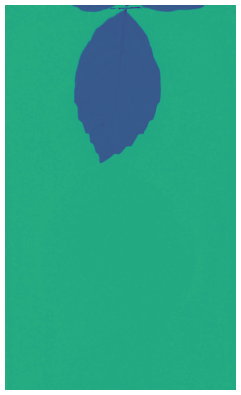

In [435]:
plt.figure(figsize=(10, 10), dpi=50)
plt.imshow(processed_images[0])
plt.axis('off')
plt.show()

In [436]:
def clustering_mask(img, num_clusters):
    labels_reshaped = kmeans_plusplus(img, num_clusters)
    return second_largest_cluster_mask(labels_reshaped, num_clusters)

def kmeans_plusplus(img, num_clusters): 
    pixel_values = np.float32(img.flatten())
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, num_clusters, None, criteria, ATTEMPTS, cv2.KMEANS_PP_CENTERS)
    # _, labels, centers = cv2.kmeans(pixel_values, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels_reshaped = labels.reshape(img.shape)
    return labels_reshaped

def second_largest_cluster_mask(labels_reshaped, num_clusters):
    masks = [cv2.inRange(labels_reshaped, cluster_id, cluster_id) for cluster_id in range(num_clusters)]
    sizes = [cv2.countNonZero(mask) for mask in masks]
    print(sizes)
    second_largest_cluster_mask = masks[sorted(zip(sizes, range(num_clusters)), reverse=True)[1][1]]
    return masks # second_largest_cluster_mask

In [437]:
def largest_component_mask(mask):
        mask = np.uint8(mask)
        _, components = cv2.connectedComponents(mask, connectivity=8)
        return np.uint8(components == np.argmax(np.bincount(components.flat)[1:]) + 1) * 255

In [438]:
def apply_mask(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)

In [439]:
def stem_cutted_mask(masked_img, stop_distance, kernel_size):
    binary_img = gray_to_binary(masked_img)

    start_row = None
    end_row = None

    for row in range(binary_img.shape[0]):
        current_row = binary_img[row, :]
        non_zero_indices = np.nonzero(current_row)[0]

        if non_zero_indices.size > 0:
            if start_row is None:
                start_row = row
            
            pixel_distance = np.max(non_zero_indices) - np.min(non_zero_indices)
            
            if pixel_distance > stop_distance:
                end_row = row
                break

    mask = np.zeros_like(masked_img[:,:,0], dtype=np.uint8)  # Changed to create 2D mask

    if start_row is not None and end_row is not None and start_row < end_row:
        mask[:start_row, :] = 1
        mask[end_row:, :] = 1

        stem_region = masked_img[start_row:end_row, :]
        if stem_region.size > 0:  # Check if stem_region is not empty
            blurred_stem = median_blur(stem_region, kernel_size)
            stem_mask = gray_to_binary(blurred_stem)
            mask[start_row:end_row, :] = stem_mask
        else:  # If stem_region is empty, fill the corresponding part of the mask with ones
            mask[start_row:end_row, :] = 1
    else:
        mask[:, :] = 1

    return mask * 255 # Return the mask as a binary image

    
def median_blur(stem_region, kernel_size):
    return cv2.medianBlur(stem_region, kernel_size)

def gray_to_binary(img):
    gray_img = rgb_to_gray(img)
    _, binary_img = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)
    return binary_img

def rgb_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [440]:
cm = clustering_mask(processed_images[0], NUM_CLUSTERS)[1]
lcm = largest_component_mask(cm)
segmented = apply_mask(original_images[0], lcm)

scm = stem_cutted_mask(segmented, STOP_DIST, KERNEL_SIZE)
lcm = largest_component_mask(scm)
smoothed = apply_mask(original_images[0], lcm)

smoothed = np.where(smoothed == 0, 255, smoothed)

[528240, 259314, 1612446]


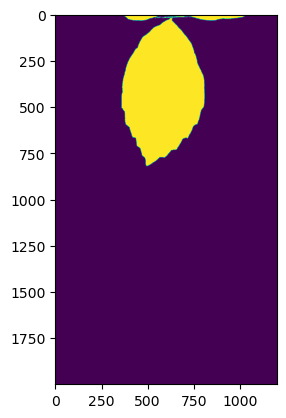

In [441]:
plt.imshow(cm)

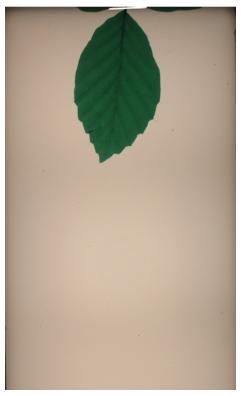

In [442]:
plt.figure(figsize=(10, 10), dpi=50)
plt.imshow(smoothed)
plt.axis('off')
plt.show()